# EDA of Cleaned Telemetry data and Feature Aggregation to Driver Record Database
Author : Ben Palmer\
Date : 02/11/2022

## Summary:

In this notebook we have successfully loaded telemetry data from the sample of 10 GrandPrix's. Shown how the telemetry data can give us insight into why certain drivers performed well and others less so.

Then we were able to create aggregate features of:
- Car Characteristics
- Circuit Characteristics
- Driver Characteristics

Which allow us to create our dataframe ready for modelling which is at a race/driver record level containing performance results, Position and Time, plus 80 features from the car telemetry data to predict these results.

## Introduction:
The FastF1 python library contains api access to the F1live data database. This contains telemetry data for every lap from the cars. Plus result and weather data. 

This is a very large a great data source, as it is expected that detail data on the car performance will allows us to accurately predict the Qualifying results.

However the data structure is very different to the Ergast Database, as explained in the following figure:

<div ><img style="height:300px"   src ='./images/database structure.png' /> </div>


The ergast database is a result database with a record per driver per race. Which is the level our target variable sits at.

The FastF1 library has telemetry data on a lap record and then interlap record.

The aim of this notebook is to generate every possible feature that can be thought of to extract information from the data on a lap and interlap level for every driver, back to driver and race record level. The features will be generated to capture feaures about the:
- Car Charateristics
- Circuit CHaracteristics
- Driver Characteristics

An initial sample of the interlap and lap data was taken from the Fastf1 library in [3_Formula1_fastf1_telemetrydata_download_cleaning](./3_Formula1_fastf1_telemetrydata_download_cleaning.ipynb). A sample was taken as the volume if interlap data is so big, just 10 grandprix's gave a dataframe with 1 million rows.

## Table of Contents:

1. [Exploratory Data Analysis](#eda)\
    1.1 [Plot of Top Two Drivers](#speed)\
    1.2 [Speed around the circuit](#speed2)\
    1.3 [Comparison around the circuit](#circuit)\
    1.4 [Correlation of Variables](#corr)

2. [Feature Aggregation](#feature)\
    2.1 [Circuit Characteristics](#circuit2)\
        - [Find corners](#corners)\
        - [Circuit Length](#circuitlength)\
        - [Circuit Straight](#straight)\
        - [Circuit corners](#corners2)\
    2.2 [Car Characteristics](#car)\
        - [Speed](#speed)\
        - [Accleration](#accler)\
        - [RPM](#rpm)\
        - [Gears](#gears)\
    2.3 [Driver Characteristics](#driver)\
    2.4 [Tyres](#tyres)\
    2.5 [Sector times](#times)\
    2.6 [Weather](#weather)

3. [Summary](#sum)

4. [Next Steps](#nextsteps)

### Imports
<a id="import"></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scripts import ds_ultils
import plotly.express as px
from scripts.f1_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')

## Load data

In [2]:
qualifying_data=pd.read_pickle('./data/clean/years_18_19_telemetry_subsetcircuits_cleaned.pkl',compression='gzip')

In [3]:
qualifying_df= qualifying_data.copy()

The qualifying data is on a delta time per lap record basis, we need to aggregate it to a record per qualifying, circuit and driver combination

To do this we do feature engineering to generate features which tell us about the circuit characteristics, driver characteristics and car characteristics.



## Data dictionary:
The telemetry data downloaded has the following data dictionary


- `raceId`(float) : id of the race linked to Ergast database
- `year` (float) : year of the Grand Prix
- `name` (float) : name of the Grand Prix
- `date` (float) : date of the qualifying session
- `time` (float) : Time of the qualifying session
- `lat_x` (float) : Latitude of the circuit
- `lng_x` (float) : Longitude of the circuit
- `circuitRef` (object) : circuit name
- `country` (object) : country name
- `alt` (float) : altitude of the circuit
- `qualifyId` (float) : id of qualifying session
- `quali_position` (float) : position of qualifying
- `positionOrder`(float) : position of race
- `points` (float) : points from race
- `points_drivers` (float): cumulative points of the season
- `position_drivers` (float): position in drivers season standing after the race
- `wins_drivers` (float) : number of wins that season
- `points_constructors` (float) : number of points the constructors have in the standings
- `position_constructors` (float) : position in constructors standings after the race
- `wins_constructors` (float) : number of constructors wins that season
- `points_constructor_ind_races` (float) : points gained in that race constructors
- `driverRef` (object) : Name of driver
- `nationality_drivers` (object) : Nationality of driver
- `constructorRef` (object) : Constructor name
- `nationality_constructors` (object) : Nationality of constructors
- `qualifying_lapId` (float) : Id of individual lap 
- `qualifying_end_lap_sessiontime` (pandas.Timedelta): Session time when the lap time was set (end of lap) 
- `qualifying_DriverNumber` (object) : Driver number
- `qualifying_LapTime` (pandas.Timedelta): Recorded lap time. 
- `qualifying_Sector1Time` (pandas.Timedelta): Sector 1 recorded time
- `qualifying_Sector2Time` (pandas.Timedelta): Sector 2 recorded time
- `qualifying_Sector3Time` (pandas.Timedelta): Sector 3 recorded time
- `qualifying_LapNumber` Recorded lap number
- `qualifying_SpeedI1` (float): Speedtrap sector 1 [km/h]
- `qualifying_SpeedI2`(float): Speedtrap sector 2 [km/h]
- `qualifying_SpeedFL` (float): Speedtrap at finish line [km/h]
- `qualifying_SpeedST`(float): Speedtrap on longest straight (Not sure) [km/h]
- `qualifying_IsPersonalBest` (bool) : Flag that indicates whether this lap is the official personal best lap of a driver. If any lap of a driver is quicker than their respective personal best lap, this means that the quicker lap is invalid and not counted. This can happen it the track limits were execeeded, for example.
- `qualifying_Compound` (object): Tyres event specific compound name: SOFT, MEDIUM, HARD, INTERMEDIATE, WET (the actual underlying compounds C1 to C5 are not differentiated).
- `qualifying_TyreLife` (float): Laps driven on this tire (includes laps in other sessions for used sets of tires)
- `qualifying_FreshTyre` (bool): Tyre had TyreLife=0 at stint start, i.e. was a new tire
- `qualifying_Stint` (int): Stint number
- `qualifying_TrackStatus` A string that contains track status numbers for all track status that occurred during this lap. ‘1’: Track clear (beginning of session ot to indicate the end of another status)
‘2’: Yellow flag (sectors are unknown)
‘4’: Safety Car
‘5’: Red Flag
‘6’: Virtual Safety Car deployed
‘7’: Virtual Safety Car ending 
- `qualifying_IsAccurate`(bool) Indicates that the lap start and end time are synced correctly with other laps. 
- `qualifying_LapStartDate` : (pandas.datetime): Timestamp at the start of the lap
- `qualifying_AirTemp` (float): Air temperature [°C]
- `qualifying_Humidity` (float): Relative humidity [%]
- `qualifying_Pressure` (float): Air pressure [mbar]
- `qualifying_Rainfall` (bool): Shows if there is rainfall 
- `qualifying_TrackTemp`  (float): Track temperature [°C]
- `qualifying_WindDirection` (int): Wind direction [°] (0°-359°)
- `qualifying_WindSpeed` (float): Wind speed [km/h]
- `qualifying_DistanceToDriverAhead` Distance to driver ahead  
- `qualifying_lap_timedelta` : (timedelta): Time (0 is start of the data slice)
- `qualifying_RPM` (int): Car RPM
- `qualifying_Speed` (float): Car speed [km/h]
- `qualifying_nGear`(int): Car gear number
- `qualifying_Throttle`(float): 0-100 Throttle pedal pressure [%]
- `qualifying_Brake`(bool): Brakes are applied or not.
- `qualifying_DRS`(int): DRS indicator 0 = Off
1 = Off
2 = (?)
3 = (?)
8 = Detected, Eligible once in Activation Zone (Noted Sometimes)
10 = On (Unknown Distinction)
12 = On (Unknown Distinction)
14 = On (Unknown Distinction)
- `qualifying_Source` (str): Flag indicating how this sample was created:
‘car’: sample from original api car data
‘pos’: sample from original api position data
‘interpolated’: this sample was artificially created; all values are computed/interpolated
- `qualifying_Distance` Distance driven between two samples
- `qualifying_RelativeDistance` distance driven since the first sampl
- `qualifying_Status` Flag - OffTrack/OnTrack 
- `qualifying_X` X position [1/10 m]
- `qualifying_Y` Y position [1/10 m]
- `qualifying_Z` Z position [1/10 m]
- `fastest_lap_milliseconds` (float) offical qualifying time in milliseconds
- `age` (float) age of driver



## Exploratory Data Analysis on Telemetry Dataset
<a id="eda"></a>

In the EDA we will investigate a couple of interesting variables to see the relationship with performance

In [4]:
print(f'The dataframe has {qualifying_df.shape[0]} rows and {qualifying_df.shape[1]} columns')

The dataframe has 1005384 rows and 69 columns


We have the fastest lap time from the results database, however this is spread over all the lap times for that driver at that race and comes from a different source it would be good to check with the lap time from the FastF1 database. To do that we will groupby driver and race and find the minimum lap time.

*1000 to covert to milliseconds

and assign a new column called `fastest_lap_milliseonds_clean` This will be important for feature aggregation lat on in the analysis

In [5]:
grouby=(qualifying_df.groupby(['raceId','driverRef'])['qualifying_LapTime'].min()*1000).unstack()
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        query= (qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver)
        qualifying_df.loc[query,'fastest_lap_milliseconds_clean'] = grouby.loc[race,driver]

997
1004
1000
994
993
1018
1025
1021
1015
1014


## Plot of Speed over the Lap for top two drivers
<a id="speed"></a>

In this section we will investigate the relationship of speed with lap time. We will select the fastest 2 drivers from the Austrain Grandprix, and the fastest times. Then plot the speed over the lap for the fastest laps.

In [5]:
#plot top two times telemetry for grand prix 1

query = (qualifying_df['positionOrder'].isin([1,2])) & (qualifying_df['raceId']==997) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds']) 
austrain_top_2_laps = qualifying_df[query].copy()

In [6]:
austrain_top_2_laps['driverRef'].unique()

array(['raikkonen', 'max_verstappen'], dtype=object)

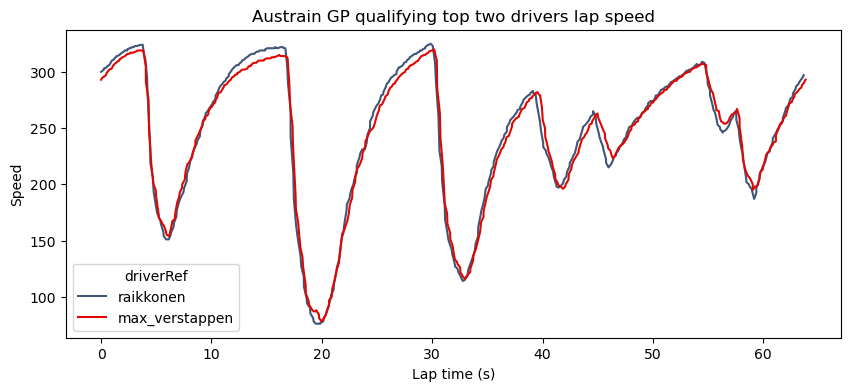

In [7]:
plt.figure(figsize=(10,4))
sns.lineplot(data=austrain_top_2_laps,
x='qualifying_lap_timedelta',
y='qualifying_Speed',
hue='driverRef')
plt.title('Austrain GP qualifying top two drivers lap speed')
plt.ylabel('Speed')
plt.xlabel('Lap time (s)')
plt.savefig('./images/austrain_2018_top_2_speed.jpg',dpi=300)
plt.show()

Here we can see the variation in speed for Max Verstappen and Kimi Raikkonnen. Kimi has a faster car in the earlier part of the lap, down the straights the Ferrai seems to reach a higher top speed whereas the Red Bull accleration starts to slow down earlier. In the corners (dips in speed) Max is able to take slightly higher speeds, especially in the final 3 turns, which means he is able to gain some time back on Kimi and only finish slightly behind him in the lap.

## Plot of speed around the Lap for the top driver
<a id="speed2"></a>

How does speed vary around the lap?

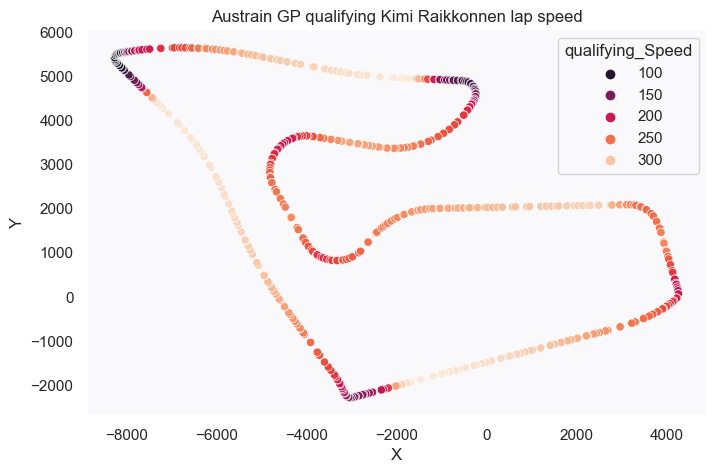

In [8]:
plt.figure(figsize=(8,5))
sns.set(rc={'axes.facecolor':'#F9F9FB','axes.grid' : False})

sns.scatterplot(data=austrain_top_2_laps[austrain_top_2_laps['driverRef']=='raikkonen'],
x='qualifying_X',
y='qualifying_Y',
hue='qualifying_Speed',
palette='rocket',
)
plt.title('Austrain GP qualifying Kimi Raikkonnen lap speed')
plt.ylabel('Y')
plt.xlabel('X')
plt.savefig('./images/austrain_2018_top_circuit_speed.jpg',dpi=300)
plt.show()

Her we can see the speed for Kimi around the lap, plotted by the X,Y coordinates. We can see the accleration and high speeds reached on the straights, and the aggressive braking at the end of the straights before the corners.

## Comparison of speed around the Lap for top two drivers
<a id="circuit"></a>

How does this compare for Max and Kimi?

In [9]:
data_temp=austrain_top_2_laps.copy()
data_temp.loc[austrain_top_2_laps['driverRef']=='max_verstappen','qualifying_X']= data_temp.loc[austrain_top_2_laps['driverRef']=='max_verstappen','qualifying_X'].apply(lambda x:x+10000)

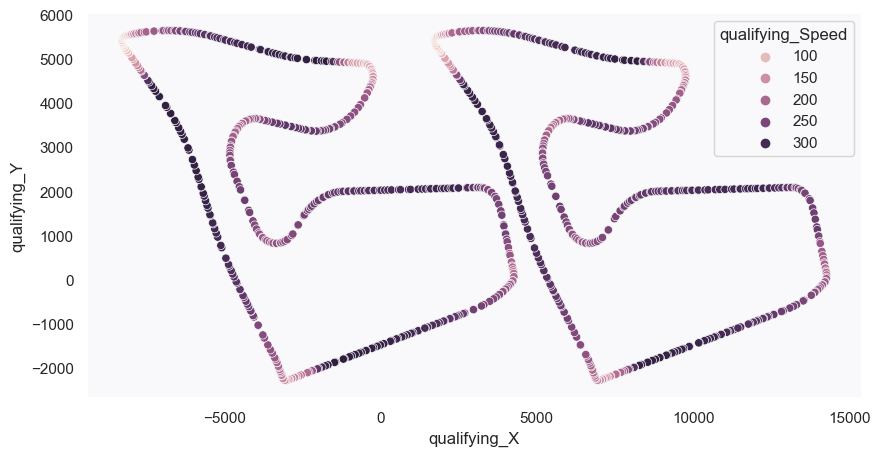

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data_temp,
x='qualifying_X',
y='qualifying_Y',
hue='qualifying_Speed'
)
plt.show()

After plotting the two drivers speeds next to each other, we can not see much difference visually, possibly inthe bottom right corner the left hand driver (Max) has a higher speed.

## Correlation between variables
<a id="corr"></a>

How is the correlation between the variables?

C:\Users\ben44\AppData\Local\Temp\ipykernel_13084\1428571343.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

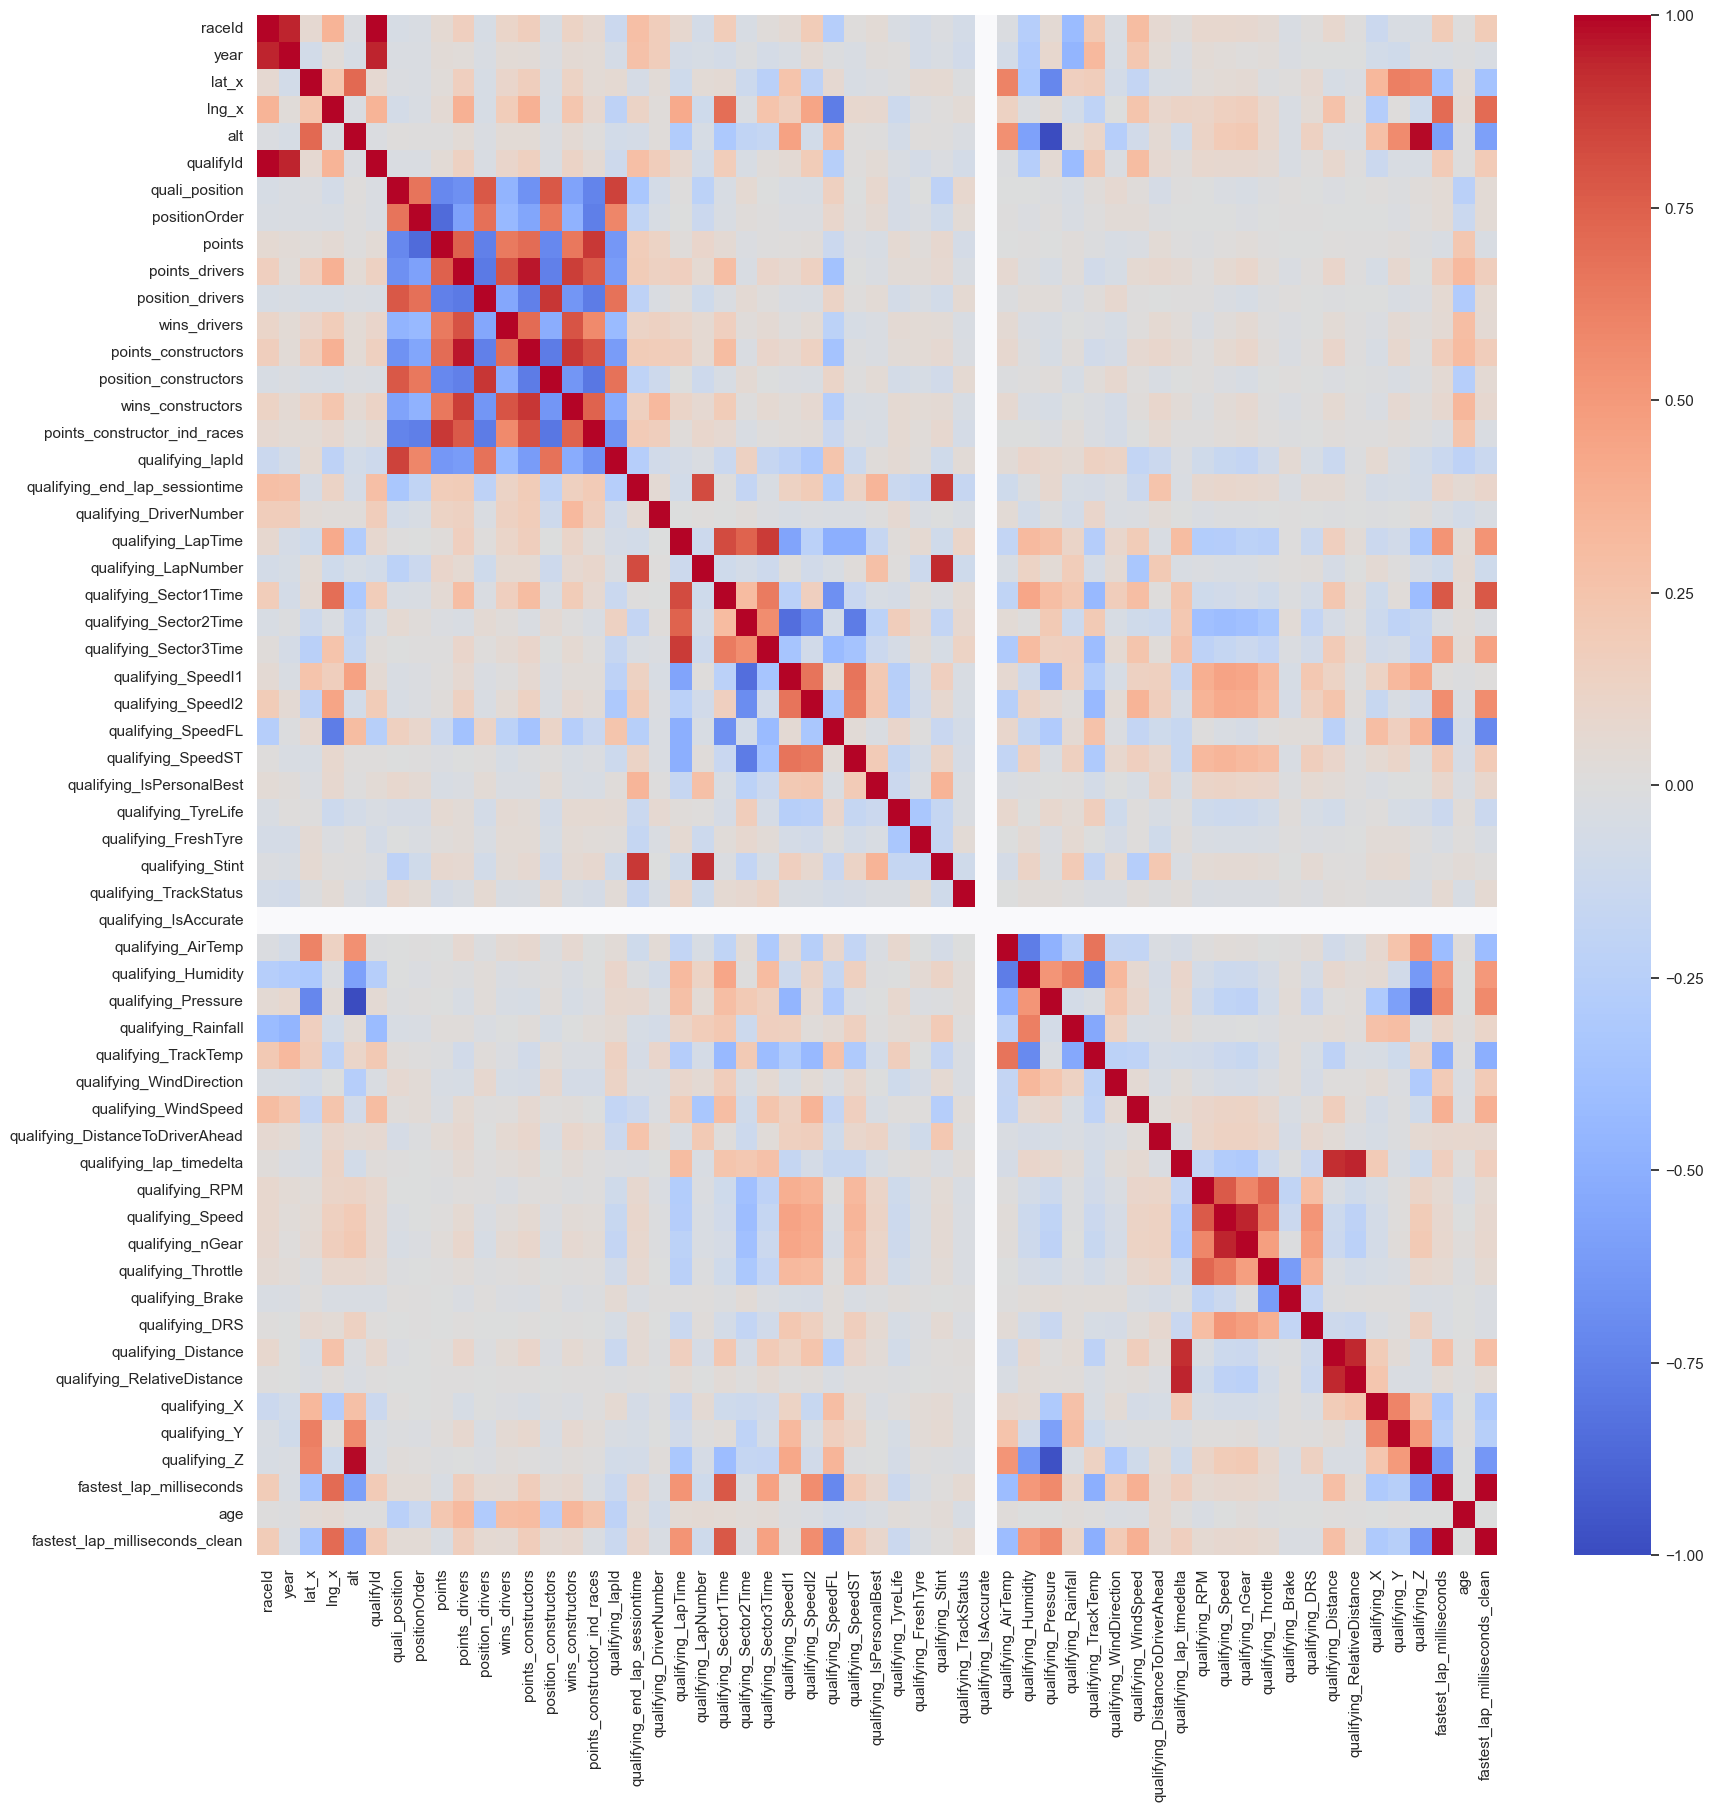

In [61]:
plt.figure(figsize=(20,20))
sns.heatmap(qualifying_df.corr(), cmap='coolwarm', vmin=-1, vmax=+1)
plt.show()

At face value the target variables `quali position` is not correlated well with any of the telemetry variables except the fastest lap time and the all the results data on points and position in the raec which is expected

This is likely because the data is at completely different record level, i.e. the speed at a single point on any lap is not likely to correlate with the qualifying position, but maybe the minimum or mean might. Hence the need to aggregate the telemetry data

The `fastest_lap`time does show corerlation with sector times as expected since sector times are just a break down of the lap time. However, the weather data does correlated with fastest lap time which may indicate there is important information in weather. Wet laps are likely to be slower. Therefore we need to keep weather data in our aggregations

The next step is the feature aggregations:

# Feature Aggregation of Telemetry
<a id="feature"></a>

This section goes through the feature aggregations, a number of helper functions have been written which sit in f1 ultils

## Circuit Characteristics
<a id="circuit2"></a>
First set of features are on the circuit. Specially the 
- Length
- Corner Tightness
- Straight length

## Find corners in a lap
<a id="corners"></a>

The basis of many features is whether the car is turning a corner or on a straight. To create these features we first need to create a flag that defines corner and not corner.

To do this we will find the second order derivative of the x and y points. Where the second order derivative is not constant, that indicates the gradient is changing and hence the car is on a corner.

Finding corners by looking for braking and accleration times was also investigated, but it performed worse than second order derivative

First test the function on one lap:

In [62]:
raikkonen_aut=qualifying_df[(qualifying_df['driverRef'] =='raikkonen') &(qualifying_df['raceId']==1018)].copy()

In [63]:
raikkonen_aut['qualifying_lapId'].unique()


array([60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.])

In [64]:
test=raikkonen_aut[raikkonen_aut['qualifying_lapId'] == 69]
test

,raceId,year,name,date,time,lat_x,lng_x,circuitRef,country,alt,...,qualifying_Source,qualifying_Distance,qualifying_RelativeDistance,qualifying_Status,qualifying_X,qualifying_Y,qualifying_Z,fastest_lap_milliseconds,age,fastest_lap_milliseconds_clean
575685,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,interpolation,0.060653,0.000014,OnTrack,1416.0,-1098.0,7215.0,64056.0,39.0,64056.0
575686,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,car,5.192222,0.001198,OnTrack,1365.0,-1112.0,7215.0,64056.0,39.0,64056.0
575687,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,pos,15.166084,0.003501,OnTrack,1272.0,-1137.0,7215.0,64056.0,39.0,64056.0
575688,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,car,25.192222,0.005815,OnTrack,1185.0,-1160.0,7214.0,64056.0,39.0,64056.0
575689,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,pos,40.239493,0.009288,OnTrack,1060.0,-1194.0,7214.0,64056.0,39.0,64056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576167,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,car,4296.272778,0.991667,OnTrack,1814.0,-992.0,7215.0,64056.0,39.0,64056.0
576168,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,pos,4302.826559,0.993179,OnTrack,1749.0,-1010.0,7215.0,64056.0,39.0,64056.0
576169,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,car,4312.576111,0.995430,OnTrack,1633.0,-1040.0,7214.0,64056.0,39.0,64056.0
576170,1018,2019,Austrian Grand Prix,2019-06-29,13:10:00,47.2197,14.7647,red_bull_ring,Austria,678.0,...,pos,4327.388177,0.998849,OnTrack,1450.0,-1090.0,7215.0,64056.0,39.0,64056.0


In [65]:
test = flag_corners(test,curvature=0.0005,interval=10,smoothing=10)

c:\Users\ben44\Documents\BEN\Brain_Station\Capstone_Project\Formula_1\scripts\f1_ultils.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot the result of the flag for the one lap:

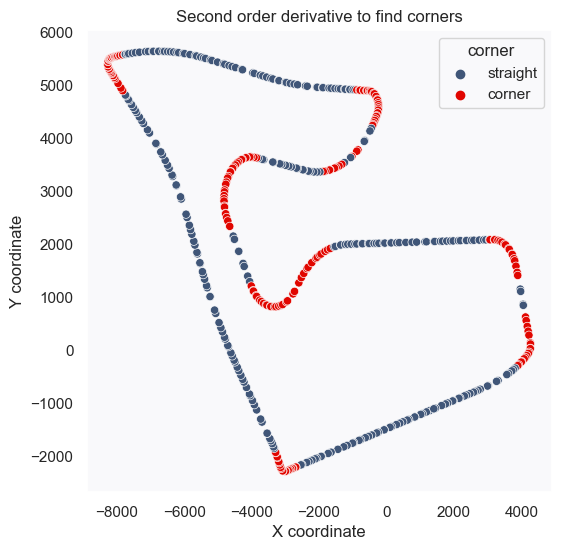

In [69]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=test,x='qualifying_X',y='qualifying_Y',hue='corner')
plt.title('Second order derivative to find corners')
plt.ylabel('Y coordinate')
plt.xlabel('X coordinate')
plt.savefig('./images/corners.jpg',dpi=300)
plt.show()

We can see that the second order derivative has successful found the corners in the lap

Lets apply this flag over all the laps in the database:

In [5]:
races = qualifying_df['raceId'].unique()
for race in races:
    lapIds = qualifying_df.loc[qualifying_df['raceId'] == race,'qualifying_lapId'].unique()
    for lap in lapIds:
        qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['qualifying_lapId']==lap),'corner']= (flag_corners(qualifying_df[(qualifying_df['raceId'] == race) & (qualifying_df['qualifying_lapId']==lap)].copy(),smoothing=10))['corner']


### Validate the function with a different race:

In [6]:
qualifying_df['raceId'].unique()

array([ 997, 1004, 1000,  994,  993, 1018, 1025, 1021, 1015, 1014],
      dtype=int64)

In [7]:
val = qualifying_df[(qualifying_df['raceId'] == 1015) & (qualifying_df['driverRef'] == 'raikkonen')]

<AxesSubplot: xlabel='qualifying_X', ylabel='qualifying_Y'>

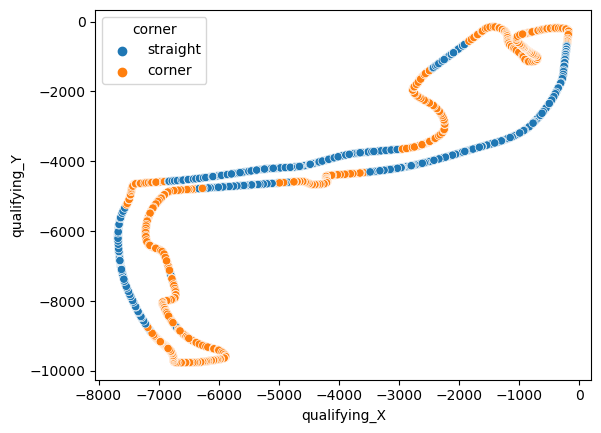

In [8]:
sns.scatterplot(data=val,x='qualifying_X',y='qualifying_Y',hue='corner')

here we can see that the dunction has successful found the corners of monaco. It has also joined up some of the corners where the track is particularly twisty. This may impact some of our calculation.

## Circuit Length
<a id="circuitlength"></a>

The next feature to create is circuit length. We can use the distance varaible for this.

Testing the approach on a single GrandPrix:

In [10]:
test = qualifying_df[qualifying_df['raceId'] == 1000]

In [11]:
lapIds = test['qualifying_lapId'].unique()

In [12]:
lengths=[]
# find the minimum distance on the lap and the max, do the difference to find the length
for lap in lapIds:
    lap_min = (test.loc[test['qualifying_lapId'] ==lap,'qualifying_Distance'].min())
    lap_max = (test.loc[test['qualifying_lapId'] ==lap,'qualifying_Distance'].max())
    lengths.append(lap_max-lap_min)
int(np.mean(lengths))

4366

### Setup the aggregate database.

Lets setup the aggregate database by grouping by the results data which came from a race/driver record level.

In [13]:
qualifying_aggr = qualifying_df.groupby(['raceId','driverRef', 'circuitRef', 'country','nationality_drivers', 'constructorRef', 'nationality_constructors',])['year', 'name', 'date', 'time', 'lat_x', 'lng_x',
        'alt', 'qualifyId', 'quali_position',
       'positionOrder', 'points', 'points_drivers', 'position_drivers',
       'wins_drivers', 'points_constructors', 'position_constructors',
       'wins_constructors', 'points_constructor_ind_races', 'age','fastest_lap_milliseconds','fastest_lap_milliseconds_clean'].mean()

C:\Users\ben44\AppData\Local\Temp\ipykernel_28472\2017904845.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  qualifying_aggr = qualifying_df.groupby(['raceId','driverRef', 'circuitRef', 'country','nationality_drivers', 'constructorRef', 'nationality_constructors',])['year', 'name', 'date', 'time', 'lat_x', 'lng_x',
C:\Users\ben44\AppData\Local\Temp\ipykernel_28472\2017904845.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  qualifying_aggr = qualifying_df.groupby(['raceId','driverRef', 'circuitRef', 'country','nationality_drivers', 'constructorRef', 'nationality_constructors',])['year', 'name', 'date', 'time', 'lat_x', 'lng_x',


In [14]:
qualifying_aggr = qualifying_aggr.reset_index()

For each lap in a race, find the distance and then take the mean of that to get circuit length:

In [15]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    lapIds = qualifying_df.loc[qualifying_df['raceId'] == race,'qualifying_lapId'].unique()
    
    lengths=[]
    for lap in lapIds:
        lap_min = (qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['qualifying_lapId'] ==lap),'qualifying_Distance'].min())
        lap_max = (qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['qualifying_lapId'] ==lap),'qualifying_Distance'].max())
        lengths.append(lap_max-lap_min)
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_length'] = int(np.mean(lengths))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [16]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,points_drivers,position_drivers,wins_drivers,points_constructors,position_constructors,wins_constructors,points_constructor_ind_races,age,fastest_lap_milliseconds,circuit_length
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,32.0,7.0,0.0,40.0,5.0,0.0,4.0,36.0,77721.0,4618.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,58.0,3.0,0.0,153.0,1.0,2.0,43.0,28.0,76213.0,4618.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,2.0,16.0,0.0,11.0,9.0,0.0,1.0,27.0,79493.0,4618.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,12.0,12.0,0.0,13.0,8.0,0.0,0.0,22.0,78463.0,4618.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,0.0,19.0,0.0,19.0,6.0,0.0,8.0,32.0,77699.0,4618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,34.0,10.0,0.0,68.0,5.0,0.0,1.0,30.0,93661.0,5825.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,0.0,20.0,0.0,1.0,10.0,0.0,0.0,21.0,95356.0,5825.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,66.0,7.0,0.0,101.0,4.0,0.0,12.0,25.0,93222.0,5825.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,19.0,16.0,0.0,52.0,7.0,0.0,6.0,20.0,94233.0,5825.0


## Circuit Straight Characteristics
<a id="straight"></a>

Next feature is to find infomration on the straights, the mean length of the straight for each race, the total sum of straights in lap and the max straight length on the lap:

This looks at every lap per race to find the total, mean and max straight length:

In [17]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    lapIds = qualifying_df.loc[qualifying_df['raceId'] == race,'qualifying_lapId'].unique()
    
    total_=[]
    mean_=[]
    max_=[]
    for lap in lapIds:
        lap_query=(qualifying_df['raceId']==race)& (qualifying_df['qualifying_lapId'] == lap)
        if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
            total_straight, mean_straight, max_straight = straight_lengths(qualifying_df[lap_query].copy())
            total_.append(total_straight)
            mean_.append(mean_straight)
            max_.append(max_straight)
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_total_straight'] = int(np.mean(total_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_mean_straight'] = int(np.mean(mean_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_max_straight'] = int(np.mean(max_))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [18]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,points_constructors,position_constructors,wins_constructors,points_constructor_ind_races,age,fastest_lap_milliseconds,circuit_length,circuit_total_straight,circuit_mean_straight,circuit_max_straight
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,40.0,5.0,0.0,4.0,36.0,77721.0,4618.0,2348.0,207.0,779.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,153.0,1.0,2.0,43.0,28.0,76213.0,4618.0,2348.0,207.0,779.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,11.0,9.0,0.0,1.0,27.0,79493.0,4618.0,2348.0,207.0,779.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,13.0,8.0,0.0,0.0,22.0,78463.0,4618.0,2348.0,207.0,779.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,19.0,6.0,0.0,8.0,32.0,77699.0,4618.0,2348.0,207.0,779.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,68.0,5.0,0.0,1.0,30.0,93661.0,5825.0,3595.0,264.0,1161.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,1.0,10.0,0.0,0.0,21.0,95356.0,5825.0,3595.0,264.0,1161.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,101.0,4.0,0.0,12.0,25.0,93222.0,5825.0,3595.0,264.0,1161.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,52.0,7.0,0.0,6.0,20.0,94233.0,5825.0,3595.0,264.0,1161.0


## Circuit Corner Characteristics
<a id="corner2"></a>

Next the characteristics of the corners:
-Total corner length
- mean corner length per lap
- max corner length per lap
- total curvature
- mean, max, and variance in curvature
- number of corners

There are multiple laps per driver and multiple drivers per race. Therefore we can find these inidividual lap features above for every lap and then take the average of to get the feature

In [23]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    lapIds = qualifying_df.loc[qualifying_df['raceId'] == race,'qualifying_lapId'].unique()
    
    total_=[]
    mean_=[]
    max_=[]
    total_curv_=[]
    mean_curv_=[]
    max_curv_=[]
    std_curv_=[]
    num_=[]
    for lap in lapIds:
        lap_query=(qualifying_df['raceId']==race) &(qualifying_df['qualifying_lapId'] == lap)
        if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
            total_straight, mean_straight, max_straight,total_curv,mean_curv,max_curv,std_curv,num_corners = corners(qualifying_df[lap_query].copy())
            total_.append(total_straight)
            mean_.append(mean_straight)
            max_.append(max_straight)
            total_curv_.append(total_curv)
            mean_curv_.append(mean_curv)
            max_curv_.append(max_curv)
            num_.append(num_corners)
            std_curv_.append(std_curv)
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_total_corner_length'] = int(np.mean(total_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_mean_corner_length'] = int(np.mean(mean_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_max_corner_length'] = int(np.mean(max_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_total_corner_curvature'] = (np.mean(total_curv_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_mean_corner_curvature'] = (np.mean(mean_curv_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_max_corner_curvature'] = (np.mean(max_curv_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_std_corner_curvature'] = (np.mean(std_curv_))
    qualifying_aggr.loc[qualifying_aggr['raceId'] == race,'circuit_number_of_corners'] = int(np.mean(num_))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [24]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,circuit_mean_straight,circuit_max_straight,circuit_total_corner_length,circuit_mean_corner_length,circuit_max_corner_length,circuit_total_corner_curvature,circuit_mean_corner_curvature,circuit_max_corner_curvature,circuit_std_corner_curvature,circuit_number_of_corners
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,207.0,779.0,2074.0,201.0,313.0,0.015701,0.001516,0.003087,0.000680,10.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,207.0,779.0,2074.0,201.0,313.0,0.015701,0.001516,0.003087,0.000680,10.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,207.0,779.0,2074.0,201.0,313.0,0.015701,0.001516,0.003087,0.000680,10.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,207.0,779.0,2074.0,201.0,313.0,0.015701,0.001516,0.003087,0.000680,10.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,207.0,779.0,2074.0,201.0,313.0,0.015701,0.001516,0.003087,0.000680,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,264.0,1161.0,1962.0,165.0,432.0,0.022326,0.001894,0.004741,0.001202,12.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,264.0,1161.0,1962.0,165.0,432.0,0.022326,0.001894,0.004741,0.001202,12.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,264.0,1161.0,1962.0,165.0,432.0,0.022326,0.001894,0.004741,0.001202,12.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,264.0,1161.0,1962.0,165.0,432.0,0.022326,0.001894,0.004741,0.001202,12.0


## Car characteristics
<a id="car"></a>

next to look at car features of:
- Speed
- Accleration
- RPM


## Max speed
<a id="speed"></a>

Lets look at top speed.

First lets find the highest speed the drivers reached in all their laps in any given race. We will call that the max max speed

In [26]:
races = qualifying_df['raceId'].unique()
for race in races:
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_max_speed'] = int( qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_Speed'].max())
    

Second lets look at every lap and calculate features for every lap and then take the average of those, for every driver in every race.

We will find for every lap for every driver the:
- top speed
- Variance in speed
- Minimum speed
- Straight speed
- variance in speed

Then take the average of these variables over all the laps completed by the drivers

These features are averaged over all the laps in the session. What if the driver did poorly in most of the laps but had a completely amazing one off lap. Our features will remove the impact of this lap.

Therefore we will also take these speed features for just the fastest lap the driver completed. We will do that be finding when the lap time equals the fastest lap time recorded.

In [27]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:        
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        top_speed=[]
        var_speed=[]
        bottom_speed_lap=[]
        straight_speed=[]
        var_straight_=[]
        query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean']) 
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
                max_speed,std_speed,min_speed,mean_straight_speed,var_straight_speed = speed_data(qualifying_df[lap_query].copy())
                top_speed.append(max_speed)
                var_speed.append(std_speed)
                bottom_speed_lap.append(min_speed)
                straight_speed.append(mean_straight_speed)
                var_straight_.append(var_straight_speed)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_fastest_lap_speed'] =int(qualifying_df.loc[query,'qualifying_Speed'].max())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'var_fastest_lap_speed'] = int(qualifying_df.loc[query,'qualifying_Speed'].std())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'min_fastest_lap_speed'] = int(qualifying_df.loc[query,'qualifying_Speed'].min())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_lap_speed'] = int(np.mean(top_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'var_lap_speed'] = int(np.mean(var_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'bottom_lap_speed'] = int(np.mean(bottom_speed_lap))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_straight_speed'] = int(np.mean(mean_straight_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'var_straight_speed'] = int(np.mean(var_straight_speed))

    

997
1004
1000
994
993
1018
1025
1021
1015
1014


## Accleration
<a id="accler"></a>

The next feature is related to accleration. This is the acceleration out of the corners. To find acceleration we need to create a flag of throttle, when the driver has it foot all the way down on the throttle i.e. trying to go as fast as he can and when his isn't as not full throttle.

We can use this flag to find the moments he is at full throttle, and then calculate the accleration of the period when he goes from off throttle to full throttle. 


In [29]:
#throttle flag
qualifying_df['Throttle_bin'] =np.where(qualifying_df['qualifying_Throttle'] < 98,'off_full_throttle','full_throttle')

In [63]:
def acceleration(x,distance=100):
    '''
    Returns the values of acceleration out of corners around the lap of a fastf1 dataframe

    Function takes each period the driver is on Full Throttle and returns the accleration 
    for the period Distance when the driver is on Full Throttle

            Parameters:
                    x (dataframe)): Fastf1 dataframe of lap telemetry data
                    distance (int): input integer

            Returns:
                    acc_ (list): List of accleration values (floats)
    '''
    df = x[x['Throttle_bin']=='full_throttle'].copy()    # dataframe of only full throttle
    indices = df.index.to_series()
    df['Group'] = ((indices - indices.shift(1)) != 1).cumsum() # find the individual groups of full throttle
    throttle_group = df['Group'].unique()
    acc_=[]
    for throttle in throttle_group:
        start_speed = df.loc[df[df['Group']==throttle].first_valid_index(),'qualifying_Speed']
        start_distance = df.loc[df[df['Group']==throttle].first_valid_index(),'qualifying_Distance']
        start_time = df.loc[df[df['Group']==throttle].first_valid_index(),'qualifying_lap_timedelta']
        df.loc[df['Group']==throttle,'distance_cumsum'] = (df.loc[df['Group']==throttle,'qualifying_Distance']- start_distance).cumsum()
        if ((df['Group']==throttle) & (df['distance_cumsum'] >distance)).sum() != 0: # make sure the group has the required distance
            end_time = df.loc[df[(df['Group']==throttle) & (df['distance_cumsum'] >distance)].first_valid_index() ,'qualifying_lap_timedelta']
            end_speed = df.loc[df[(df['Group']==throttle) & (df['distance_cumsum'] >distance)].first_valid_index() ,'qualifying_Speed']
           
            acc_.append((end_speed-start_speed)/(end_time-start_time)) # accleration change in speed over time
    
    if len(acc_) >1:
        acc_.pop(0)
    return acc_

For each lap, per driver per race. Find the list of acclerations out of the corners for that lap. Return the top accleration, variance in accleration and minimum accleration for that lap.

Then return mean of these values over all the laps in the session.

Also return the values for just the fastest lap of the driver.

In [65]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        #print(driver)
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        top_accleration=[]
        var_accleration=[]
        min_accleration=[]
        straight_speed=[]
        var_straight_=[]
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean']) 
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if int(qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all()) == 1:  
                acc_= acceleration(qualifying_df[lap_query].copy())
                if len(acc_) !=0:                
                    top_accleration.append(np.max(acc_))
                    var_accleration.append(np.std(acc_))
                    min_accleration.append(np.min(acc_))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_fastest_accleration'] =int(np.max(acceleration(qualifying_df[fastestlap_query].copy())))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'var_fastest_accleration'] = int(np.std(acceleration(qualifying_df[fastestlap_query].copy())))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'min_fastest_accleration'] = int(np.min(acceleration(qualifying_df[fastestlap_query].copy())))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_top_lap_accleration'] = int(np.mean(top_accleration))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_var_lap_accleration'] = int(np.mean(var_accleration))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_min_lap_accleration'] = int(np.mean(min_accleration))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [67]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,var_lap_speed,bottom_lap_speed,mean_straight_speed,var_straight_speed,max_fastest_accleration,var_fastest_accleration,min_fastest_accleration,mean_top_lap_accleration,mean_var_lap_accleration,mean_min_lap_accleration
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,65.0,73.0,249.0,45.0,54.0,15.0,1.0,51.0,13.0,6.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,64.0,73.0,175.0,61.0,54.0,15.0,1.0,48.0,12.0,7.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,65.0,76.0,259.0,39.0,55.0,16.0,9.0,53.0,12.0,15.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,64.0,72.0,250.0,45.0,56.0,17.0,1.0,48.0,12.0,10.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,65.0,72.0,253.0,48.0,49.0,15.0,0.0,50.0,12.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,63.0,100.0,258.0,39.0,51.0,7.0,27.0,51.0,6.0,29.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,62.0,88.0,257.0,42.0,48.0,7.0,25.0,45.0,8.0,19.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,64.0,86.0,261.0,36.0,47.0,6.0,29.0,49.0,7.0,24.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,66.0,78.0,244.0,58.0,53.0,14.0,3.0,50.0,9.0,19.0


## RPM
<a id="rpm"></a>

The next car characteristics is RPM, RPM is the revolution per minute of the engine and can tell us about the engines performance 

Lets evaluate the RPM of a single lap:

In [68]:
qualifying_df['qualifying_RPM'].describe()

count    1.005384e+06
mean     9.832860e+03
std      1.667670e+03
min      0.000000e+00
25%      8.761000e+03
50%      1.039700e+04
75%      1.112500e+04
max      1.331500e+04
Name: qualifying_RPM, dtype: float64

In [69]:
fastestlap_query = (qualifying_df['raceId']==997)& (qualifying_df['driverRef'] == 'hamilton') & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean'])
test = qualifying_df[fastestlap_query]

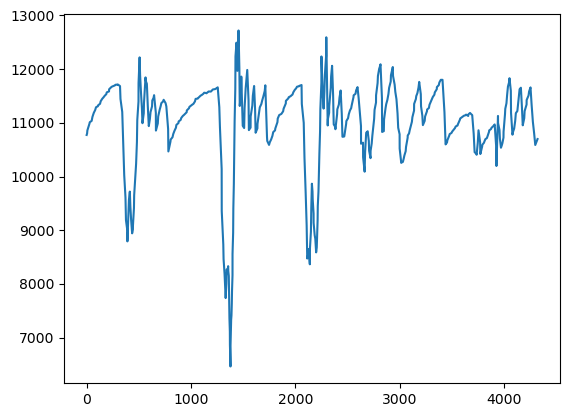

In [70]:
plt.plot(test['qualifying_Distance'],test['qualifying_RPM'])

We can see that the engine RPM drops in the corners, and then is spiking down the straights related to the gear changes of the car. the spikes get longer as the car starts to acclerate less fast and reach its maximum speed. The difference in RPM between gear changes (Variance) may tell us something about gear ratio and enginer performance

Below we calculate for all laps per driver per race, the max rpm, mean rpm on the straight and variance of RPM on the straight.

We then take the mean of these values over all the laps

We also take the fastest laps values as addittional features 

In [71]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        #print(driver)
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        max_max_rpm=[]     
        straight_var_rpm=[]
        straight_mean_rpm =[]
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean']) 
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:  # track status 1 to ensure there are no yellow flags on the lap and the driver is green to go fast
                max_rpm,mean_straight_rpm, var_straight_rpm= rpm(qualifying_df[lap_query].copy())
                max_max_rpm.append(np.mean(max_rpm))            
                straight_mean_rpm.append(np.mean(mean_straight_rpm))
                straight_var_rpm.append(np.mean(var_straight_rpm))
            max_rpm_fl,mean_straight_rpm_fl, var_straight_rpm_fl= rpm(qualifying_df[fastestlap_query].copy())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_fastest_lap_rpm'] =int(max_rpm_fl)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'var_fastest_lap_straight_rpm'] = int(np.mean(var_straight_rpm_fl))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_fastest_lap_straight_rpm'] = int(np.mean(mean_straight_rpm_fl))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'max_max_rpm'] = int(np.max(max_max_rpm))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_var_straight_rpm'] = int(np.mean(straight_var_rpm))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'mean_straight_rpm'] = int(np.mean(straight_mean_rpm))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [72]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,min_fastest_accleration,mean_top_lap_accleration,mean_var_lap_accleration,mean_min_lap_accleration,max_fastest_lap_rpm,var_fastest_lap_straight_rpm,mean_fastest_lap_straight_rpm,max_max_rpm,mean_var_straight_rpm,mean_straight_rpm
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,1.0,51.0,13.0,6.0,11866.0,503.0,10775.0,12107.0,562.0,10747.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,1.0,48.0,12.0,7.0,12187.0,736.0,10952.0,12536.0,903.0,10537.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,9.0,53.0,12.0,15.0,12417.0,663.0,11073.0,12740.0,994.0,10756.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,1.0,48.0,12.0,10.0,12441.0,510.0,10771.0,12865.0,682.0,10704.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,0.0,50.0,12.0,10.0,12300.0,568.0,11106.0,12603.0,733.0,10801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,27.0,51.0,6.0,29.0,11952.0,464.0,11022.0,12144.0,492.0,10928.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,25.0,45.0,8.0,19.0,12316.0,754.0,10976.0,12803.0,904.0,10762.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,29.0,49.0,7.0,24.0,11713.0,716.0,10859.0,11868.0,945.0,10622.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,3.0,50.0,9.0,19.0,12467.0,519.0,11195.0,12760.0,710.0,10921.0


## Gears
<a id="gears"></a>

The time spent in a individual gear may tell us about the performance of the car. The feature we have is the number of the gear the driver is around the lap.

What we need to do is then calculate the time spent in each gear for the lap using the lap time delta column.
The function gear_dict returns this as a dictionary for each gear

Then we can average these lap for all the laps per driver per race.

Plus take the fastest lap gear times per driver per race

In [73]:
qualifying_df['qualifying_nGear']

0          7.0
1          7.0
2          7.0
3          8.0
4          8.0
          ... 
1005379    7.0
1005380    7.0
1005381    7.0
1005382    7.0
1005383    7.0
Name: qualifying_nGear, Length: 1005384, dtype: float64

In [74]:
qualifying_df['qualifying_nGear'].describe()

count    1.005384e+06
mean     4.628182e+00
std      1.942573e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      8.000000e+00
Name: qualifying_nGear, dtype: float64

In [75]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        #print(driver)
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        gear_1_times=[]
        gear_2_times=[]  
        gear_3_times=[]  
        gear_4_times=[]  
        gear_5_times=[]  
        gear_6_times=[]  
        gear_7_times=[]  
        gear_8_times=[]       
    
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean']) 
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:                
                gear_dict= gear_data(qualifying_df[lap_query].copy())
                gear_1_times.append(np.mean(gear_dict['gear_1']))            
                gear_2_times.append(np.mean(gear_dict['gear_2']))
                gear_3_times.append(np.mean(gear_dict['gear_3']))
                gear_4_times.append(np.mean(gear_dict['gear_4']))            
                gear_5_times.append(np.mean(gear_dict['gear_5']))
                gear_6_times.append(np.mean(gear_dict['gear_6']))
                gear_7_times.append(np.mean(gear_dict['gear_7']))
                gear_8_times.append(np.mean(gear_dict['gear_8']))
        gear_dict_fl= gear_data(qualifying_df[fastestlap_query].copy())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear1_time'] =int(np.mean(gear_1_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear2_time'] = int(np.mean(gear_2_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear3_time'] = int(np.mean(gear_3_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear4_time'] = int(np.mean(gear_4_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear5_time'] = int(np.mean(gear_5_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear6_time'] = int(np.mean(gear_6_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear7_time'] = int(np.mean(gear_7_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear8_time'] = int(np.mean(gear_8_times))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear1_time_fl'] =int(np.mean(gear_dict_fl['gear_1']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear2_time_fl'] = int(np.mean(gear_dict_fl['gear_2']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear3_time_fl'] = int(np.mean(gear_dict_fl['gear_3']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear4_time_fl'] = int(np.mean(gear_dict_fl['gear_4']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear5_time_fl'] = int(np.mean(gear_dict_fl['gear_5']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear6_time_fl'] = int(np.mean(gear_dict_fl['gear_6']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear7_time_fl'] = int(np.mean(gear_dict_fl['gear_7']))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_gear8_time_fl'] = int(np.mean(gear_dict_fl['gear_8']))

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [76]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,avg_gear7_time,avg_gear8_time,avg_gear1_time_fl,avg_gear2_time_fl,avg_gear3_time_fl,avg_gear4_time_fl,avg_gear5_time_fl,avg_gear6_time_fl,avg_gear7_time_fl,avg_gear8_time_fl
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,14.0,13.0,0.0,2.0,7.0,13.0,6.0,9.0,16.0,14.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,10.0,12.0,0.0,0.0,9.0,15.0,8.0,8.0,13.0,14.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,9.0,10.0,0.0,3.0,7.0,16.0,9.0,13.0,13.0,11.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,8.0,8.0,0.0,0.0,11.0,20.0,7.0,12.0,10.0,12.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,10.0,11.0,0.0,2.0,7.0,15.0,8.0,8.0,15.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,12.0,14.0,0.0,0.0,10.0,20.0,12.0,18.0,11.0,14.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,13.0,11.0,0.0,0.0,12.0,18.0,12.0,12.0,13.0,16.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,22.0,15.0,0.0,0.0,10.0,11.0,9.0,13.0,22.0,18.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,15.0,13.0,0.0,0.0,9.0,19.0,13.0,13.0,14.0,16.0


## Driver Characteristics
<a id="driver"></a>

We have established the car characteristics now we want to find characteristics of the driver. These are features around the drivers braking distance, use of the DRS and confidence in the corners.

We will calculate:
- The time the DRS is open around the lap (in qualifying the drivers can open the rear wing flap when they want to reduce drag, but have to close it for corner downforce)
- the time the drivers are on the brakes & distance travelled on the brakes - how aggressive brakes are they
- Bottom speed in the corners - the cornering confidence:
    - calculating the minimum speed
    - max speed in corner 
    - bottom speed in the tightest corner

These will be averaged over all the laps

Plus taken for the fastest lap of qualifying for that driver

In [77]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        #print(driver)
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        lap_time_on_brakes=[]
        lap_distance_on_brakes=[]
        lap_bottom_speed =[]
        lap_max_corner_speed =[]
        lap_bottom_speed_tightness_corner =[]
        drs_open_time=[]
        drs_open_distance=[]
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
                drs_time,drs_distance=DRS_open(qualifying_df[lap_query].copy())
                drs_open_distance.append(drs_distance)
                drs_open_time.append(drs_time)
                bottom_speed,max_corner_speed,bottom_speed_tightness_corner=driver_corners(qualifying_df[lap_query].copy())
                lap_bottom_speed_tightness_corner.append(bottom_speed_tightness_corner)
                lap_bottom_speed.append(np.mean(bottom_speed)) #mean lap bottom speed of all the corners
                lap_max_corner_speed.append(np.max(max_corner_speed)) # mean of all the laps top speed in the corner
                time_on_brakes, distance_on_brakes=driver_brake(qualifying_df[lap_query].copy())
                lap_time_on_brakes.append(time_on_brakes)
                lap_distance_on_brakes.append(distance_on_brakes)
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean']) 
        fl_time_on_brakes, fl_distance_on_brakes=driver_brake(qualifying_df[fastestlap_query].copy())
        fl_drs_time,fl_drs_distance=DRS_open(qualifying_df[fastestlap_query].copy())
        fl_bottom_speed,fl_max_corner_speed,bottom_speed_tightness_corner=driver_corners(qualifying_df[fastestlap_query].copy())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_time_on_brake'] =int(np.mean(lap_time_on_brakes))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_distance_on_brake'] = int(np.mean(lap_distance_on_brakes))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_time_on_DRS'] = int(np.mean(drs_open_time))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_distance_on_DRS'] = int(np.mean(drs_open_distance))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_bottom_speed_corner'] = int(np.mean(lap_bottom_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_max_speed_corner'] = int(np.mean(lap_max_corner_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_bottom_speed_tightest_corner'] = int(np.mean(lap_bottom_speed_tightness_corner))

        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_time_on_brake'] =int(fl_time_on_brakes)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_distance_on_brake'] = int(fl_distance_on_brakes)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_time_on_DRS'] = int(fl_drs_time)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_distance_on_DRS'] = int(fl_drs_distance)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_bottom_speed_corner'] = int(np.mean(fl_bottom_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_max_speed_corner'] = int(np.max(fl_max_corner_speed))
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_lap_bottom_speed_tightest_corner'] = int(bottom_speed_tightness_corner)
        

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [78]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,avg_lap_bottom_speed_corner,avg_lap_max_speed_corner,avg_lap_bottom_speed_tightest_corner,fl_lap_time_on_brake,fl_lap_distance_on_brake,fl_lap_time_on_DRS,fl_lap_distance_on_DRS,fl_lap_bottom_speed_corner,fl_lap_max_speed_corner,fl_lap_bottom_speed_tightest_corner
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,148.0,266.0,88.0,13.0,589.0,15.0,1245.0,154.0,270.0,88.0
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,143.0,260.0,90.0,10.0,527.0,14.0,1216.0,160.0,277.0,92.0
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,133.0,262.0,81.0,11.0,563.0,14.0,1195.0,151.0,274.0,82.0
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,139.0,255.0,80.0,11.0,546.0,14.0,1236.0,154.0,268.0,91.0
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,142.0,265.0,78.0,12.0,567.0,14.0,1222.0,156.0,276.0,107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,159.0,288.0,137.0,11.0,601.0,19.0,1625.0,158.0,288.0,176.0
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,139.0,256.0,104.0,14.0,747.0,18.0,1597.0,155.0,285.0,112.0
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,150.0,277.0,130.0,12.0,624.0,20.0,1687.0,164.0,284.0,118.0
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,142.0,273.0,125.0,14.0,756.0,19.0,1613.0,155.0,288.0,161.0


## Tyres
<a id="tyres"></a>

What tyres are the driver on? How used is the tyre, this could impact the performance.

In [ ]:
qualifying_df['qualifying_Compound'].value_counts()

SOFT            466598
HYPERSOFT       195040
ULTRASOFT       147808
SUPERSOFT        77566
INTERMEDIATE     46879
WET              38527
MEDIUM           32966
Name: qualifying_Compound, dtype: int64

Majority of the laps are on the soft tyre, even soft tyres are used less frequently. Interemediate and wet are wet weather tyres. Medium is a harder compound. 

As described previously at any given weekend the drivers are set the tyre choice options they can use by the manufacture. From them typically the softest is the fastest tyre and hence the teams will use the fastest tyre they can for qualifying.

In [80]:
qualifying_df['qualifying_FreshTyre'].value_counts()

True     976118
False     29266
Name: qualifying_FreshTyre, dtype: int64

Qualifying is mostly fresh tyre unlikely to be useful metric

In [81]:
qualifying_df['qualifying_TyreLife'].describe()

count    1.005384e+06
mean     3.034159e+00
std      1.484089e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.400000e+01
Name: qualifying_TyreLife, dtype: float64

Minimum number of laps a tyre has been used is 1 - which is the outlap from the pits. The maximum number of laps is 14. Indicating that drivers like to use the freshest tyres possible to complete there fast laps.

We will calculate for the fastest lap for each driver, the tyre life and the compound they were on. The number average tyre life for all the laps was not considered as useful a prediction metric because that should average out to a low number as described above. However the "freshness" of the tyre on the fastest lap maybe a good prediction of the lap time. Similar logic can be applied for the compound as well.

In [82]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean'])
        fastestlap_tyre = (qualifying_df.loc[fastestlap_query,'qualifying_Compound'].mode().values[0])
        fastestlap_tyre_life=(qualifying_df.loc[fastestlap_query,'qualifying_TyreLife'].mean())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_tyre'] =fastestlap_tyre
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fl_tyre_life'] = fastestlap_tyre_life

997
1004
1000
994
993
1018
1025
1021
1015
1014


## sector time aggregate
<a id="times"></a>

We have data on the sector times, this is the time taken to complete different portion of the lap. Certain cars/drivers may suit the characteristics of different sectors of the lap.

We will calculate the average sector time for each sector for all the laps

Plus return the sector times for the fastest lap only

For all the drivers and races:

In [83]:
qualifying_df['qualifying_Sector1Time'].describe()

count    1.005384e+06
mean     2.604043e+01
std      7.764839e+00
min      1.595200e+01
25%      1.936200e+01
50%      2.378300e+01
75%      3.272900e+01
max      5.622300e+01
Name: qualifying_Sector1Time, dtype: float64

In [84]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        avg_Sector1=[]
        avg_Sector2=[]
        avg_Sector3=[]
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
                avg_Sector1.append(qualifying_df.loc[lap_query,'qualifying_Sector1Time'].mean())
                avg_Sector2.append(qualifying_df.loc[lap_query,'qualifying_Sector2Time'].mean())
                avg_Sector3.append(qualifying_df.loc[lap_query,'qualifying_Sector3Time'].mean())
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean'])
        fastestlap_Sector1 = (qualifying_df.loc[fastestlap_query,'qualifying_Sector1Time'].mean())
        fastestlap_Sector2=(qualifying_df.loc[fastestlap_query,'qualifying_Sector2Time'].mean())
        fastestlap_Sector3=(qualifying_df.loc[fastestlap_query,'qualifying_Sector3Time'].mean())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_Sector1'] =fastestlap_Sector1
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_Sector2'] = fastestlap_Sector2
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_Sector3'] = fastestlap_Sector3
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avglap_Sector1'] =np.mean(avg_Sector1)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avglap_Sector2'] = np.mean(avg_Sector2)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avglap_Sector3'] = np.mean(avg_Sector3)
        

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [85]:
qualifying_aggr


,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,fl_lap_max_speed_corner,fl_lap_bottom_speed_tightest_corner,fl_tyre,fl_tyre_life,fastestlap_Sector1,fastestlap_Sector2,fastestlap_Sector3,avglap_Sector1,avglap_Sector2,avglap_Sector3
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,270.0,88.0,SOFT,2.0,22.119,28.913,26.689,22.835222,30.568444,28.153444
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,277.0,92.0,SUPERSOFT,2.0,21.528,28.366,26.319,23.765333,31.612500,30.362000
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,274.0,82.0,SUPERSOFT,4.0,22.383,29.750,27.360,24.981800,36.156200,30.434600
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,268.0,91.0,SUPERSOFT,2.0,22.119,29.501,26.843,23.887500,32.403125,29.813000
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,276.0,107.0,SOFT,2.0,21.878,29.011,26.810,23.728071,32.493429,29.558929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,288.0,176.0,SOFT,2.0,34.129,32.170,27.362,34.240667,32.285833,27.613500
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,285.0,112.0,SOFT,2.0,34.423,32.681,28.252,37.703667,36.613333,31.122333
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,284.0,118.0,SOFT,2.0,34.138,31.815,27.269,35.292500,33.726500,31.214250
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,288.0,161.0,SOFT,2.0,34.159,32.345,27.729,36.772167,36.066333,31.962333


## Weather
<a id="weather"></a>

As shown in the initial EDA weather has some correlation with lap time. This is likely because wet conditions make the track slipperly and drivers have to driver slower to keep the car on the road.

We have a flag of whether it is raining or not, and the humidity and track temperature.

The flag of rainfall tell us around the track whether it is raining or not. This can tell us if one part of the track is wet and the other is not. Therefore we can calculate a percentage of the lap that is raining from this

In [86]:
qualifying_df['qualifying_Rainfall'].value_counts()

False    808039
True     197345
Name: qualifying_Rainfall, dtype: int64

In [87]:
qualifying_df['qualifying_Humidity']

0          45.3
1          45.3
2          45.3
3          45.3
4          45.3
           ... 
1005379    58.9
1005380    58.9
1005381    58.9
1005382    58.9
1005383    58.9
Name: qualifying_Humidity, Length: 1005384, dtype: float64

In [88]:
qualifying_df['qualifying_TrackTemp']

0          34.9
1          34.9
2          34.9
3          34.9
4          34.9
           ... 
1005379    31.8
1005380    31.8
1005381    31.8
1005382    31.8
1005383    31.8
Name: qualifying_TrackTemp, Length: 1005384, dtype: float64

For every lap in for each driver for each race, we will calculate the percentage percentage rainfall of that lap, the average track temperature of that lap and average humidity of that lap.

We will average these for all the laps for the driver.

Plus return the absolute values for the fastest lap.

In [89]:
races = qualifying_df['raceId'].unique()
for race in races:
    print(race)
    drivers = qualifying_df.loc[qualifying_df['raceId'] == race,'driverRef'].unique()
    for driver in drivers:
        laps = qualifying_df.loc[(qualifying_df['raceId'] == race) & (qualifying_df['driverRef'] == driver),'qualifying_lapId'].unique()
        avg_lap_percentagerainfall=[]
        avg_lap_track_temperature=[]
        avg_lap_humidty=[]
        for lap in laps:
            lap_query=(qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) &(qualifying_df['qualifying_lapId'] == lap)
            if qualifying_df.loc[lap_query,'qualifying_TrackStatus'].all() == 1:
                avg_lap_percentagerainfall.append(qualifying_df.loc[fastestlap_query,'qualifying_Rainfall'].sum()/len(qualifying_df.loc[fastestlap_query,'qualifying_Rainfall'])*100)
                avg_lap_track_temperature.append(qualifying_df.loc[lap_query,'qualifying_TrackTemp'].mean())
                avg_lap_humidty.append(qualifying_df.loc[lap_query,'qualifying_Humidity'].mean())
        fastestlap_query = (qualifying_df['raceId']==race)& (qualifying_df['driverRef'] == driver) & ((qualifying_df['qualifying_LapTime']*1000)==qualifying_df['fastest_lap_milliseconds_clean'])
        fastestlap_percentagerainfall = (qualifying_df.loc[fastestlap_query,'qualifying_Rainfall'].sum()/len(qualifying_df.loc[fastestlap_query,'qualifying_Rainfall'])*100)
        fastestlap_track_temperature=(qualifying_df.loc[fastestlap_query,'qualifying_TrackTemp'].mean())
        fastestlap_humidity=(qualifying_df.loc[fastestlap_query,'qualifying_Humidity'].mean())
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_percentagerainfall'] =fastestlap_percentagerainfall
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_track_temperature'] = fastestlap_track_temperature
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'fastestlap_humidity'] = fastestlap_humidity
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_percentagerainfall'] =np.mean(avg_lap_percentagerainfall)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_track_temperature'] = np.mean(avg_lap_track_temperature)
        qualifying_aggr.loc[(qualifying_aggr['raceId'] == race) & (qualifying_aggr['driverRef'] == driver) ,'avg_lap_humidty'] = np.mean(avg_lap_humidty)

997
1004
1000
994
993
1018
1025
1021
1015
1014


In [90]:
qualifying_aggr

,raceId,driverRef,circuitRef,country,nationality_drivers,constructorRef,nationality_constructors,year,lat_x,lng_x,...,fastestlap_Sector3,avglap_Sector1,avglap_Sector2,avglap_Sector3,fastestlap_percentagerainfall,fastestlap_track_temperature,fastestlap_humidity,avg_lap_percentagerainfall,avg_lap_track_temperature,avg_lap_humidty
0,993,alonso,catalunya,Spain,Spain,mclaren,UK,2018.0,41.5700,2.26111,...,26.689,22.835222,30.568444,28.153444,100.0,26.4,79.2,100.0,27.255556,77.311111
1,993,bottas,catalunya,Spain,Finland,mercedes,Germany,2018.0,41.5700,2.26111,...,26.319,23.765333,31.612500,30.362000,100.0,26.4,79.2,100.0,26.950000,77.883333
2,993,ericsson,catalunya,Spain,Sweden,sauber,Switzerland,2018.0,41.5700,2.26111,...,27.360,24.981800,36.156200,30.434600,0.0,27.6,76.1,0.0,27.620000,76.440000
3,993,gasly,catalunya,Spain,France,toro_rosso,Italy,2018.0,41.5700,2.26111,...,26.843,23.887500,32.403125,29.813000,100.0,26.8,77.8,100.0,27.462500,76.587500
4,993,grosjean,catalunya,Spain,France,haas,USA,2018.0,41.5700,2.26111,...,26.810,23.728071,32.493429,29.558929,100.0,27.1,77.1,100.0,27.135714,77.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1025,ricciardo,sochi,Russia,Australia,renault,France,2019.0,43.4057,39.95780,...,27.362,34.240667,32.285833,27.613500,0.0,29.9,58.9,0.0,30.533333,60.000000
193,1025,russell,sochi,Russia,UK,williams,UK,2019.0,43.4057,39.95780,...,28.252,37.703667,36.613333,31.122333,0.0,30.9,60.4,0.0,31.133333,61.166667
194,1025,sainz,sochi,Russia,Spain,mclaren,UK,2019.0,43.4057,39.95780,...,27.269,35.292500,33.726500,31.214250,0.0,29.9,58.9,0.0,30.725000,60.300000
195,1025,stroll,sochi,Russia,Canada,racing_point,UK,2019.0,43.4057,39.95780,...,27.729,36.772167,36.066333,31.962333,0.0,30.6,60.7,0.0,30.966667,60.800000


That conculdes all the feature aggregations, for our sample dataset. We know have a dataframe with 101 columns. 101 features.

## Save the Data

We have finished all the feature aggregations and created the final dataframe. This contains our features of:
- Car Characteristics
- Driver Characteristics
- Circuit Characteristics

Save the dataframe for further analysis in the next notebook:

In [111]:
qualifying_aggr.to_csv('./data/model_data/formula1_2018_2019_5GP_aggregated.csv',index=False)

## Summary
<a id="sum"></a>

In this notebook we have successfully loaded telemetry data from the sample of 10 GrandPrix's. Shown how the telemetry data can give us insight into why certain drivers performed well and others less so.

Then we were able to create aggregate features of:
- Car Characteristics
- Circuit Characteristics
- Driver Characteristics

Which allow us to create our dataframe ready for modelling which is at a race/driver record level containing performance results, Position and Time, plus 80 features from the car telemetry data to predict these results.

## Next Steps
<a id="nextsteps"></a>

The next steps is to validate that the features we have created are useful in the prediction of Qualifying Position and Qualifying Lap time. Plus can we reduce the features down to just the saliniate features to predict the results. This is very important for our problem as even with the full GrandPrix dataset of 2018 to 2022 we do not have a large record database and therefore need to reduce dimensionality to avoid overfitting and the curse of dimensionality! 
